
# A point analysis of weak learning models

    Notebook version: 1.1 (Feb 2, 2017)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
               

    Changes: v.1.0 - First version

In [7]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
# import csv     # To read csv files
# import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
# from sklearn import neighbors, datasets
import wlc.WLweakener2 as wlw


## 1. Introduction.

In this notebook I analyze the behavior of a sample based estimates of a $C$-dimensional probability vector $\boldsymbol{\eta}$ from  binary instances.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of labels generated from $\boldsymbol{\eta}$, and estimates based on weak labels.

To do so, we will generate a dataset of labels drawn from $\boldsymbol{\eta}$, and one or more datasets of weak labels drawn from $\boldsymbol{\eta}$ and from a given mixing matrix ${\bf M}$.

First we define some configurable parameters:

In [8]:
C = 3                             # Number of classes
K = 1000                          # Sample size
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

# Mixing matrix
M = wlw.computeM(C, beta=0.5, method='quasi_IPL')
M = wlw.computeM(C, beta=0.6, method='noisy')
M = M[np.sum(M, axis=1) > 0]   # This is to remove zero rows, which are not relevant
print "Mixing matrix:"
print M

Mixing matrix:
[[ 0.4  0.3  0.3]
 [ 0.3  0.4  0.3]
 [ 0.3  0.3  0.4]]


### 1.1. Dataset generation.

In the following we will generate a dataset of labels and their corresponding weak labels

In [9]:
# Generate true labels
I = np.eye(C)
iy = np.random.choice(np.arange(0, C), size=K, p=eta)
y = I[iy]

# Generate weak label indices
iz = wlw.generateWeak(iy, M, C)

### 1.2. Supervised, sample based estimation.

In the supervised setting, ${\bf y}$ is observed an the optimal sample based estimate of $\boldsymbol{\eta}$ (minimizing any Bregmann divergence) based the observed labels is the sample average

In [10]:
f = np.mean(y, axis=0)
print "Supervised estimate: {0}".format(f)
e2 = np.mean((f - eta)**2)
print "Square error: {0}".format(e2)

Supervised estimate: [ 0.508  0.204  0.288]
Square error: 7.46666666667e-05


### 1.3. Learning from weak labels.

There are many ways to estimate $\boldsymbol{\eta}$ from the weak labels. We consider here a representative sample of them:

#### 1.3.1. Averaging virtual labels

In [11]:
v = wlw.computeVirtual(iz, C, method='quasi_IPL')
print "Virtual labels are:"
print v
f_v = np.mean(v, axis=0)

print "Virtual label estimate: {0}".format(f_v)
e2 = np.mean((f_v - eta)**2)
print "Square error: {0}".format(e2)

Virtual labels are:
[[ 0.          1.          0.        ]
 [ 0.          0.          1.        ]
 [ 0.33333333  0.33333333  0.33333333]
 ..., 
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]]
Virtual label estimate: [ 0.11366667  0.45666667  0.42966667]
Square error: 0.0773148888889


#### 1.3.2. Maximum Likelihood Estimate

The ML estimate cannot be computed analytically, but we can apply expectation maximization.

In [17]:
def computeML(iz, M, f0=None, max_iter=1e10, echo='off'):
    """
    Compute the ML estimate of a probability vector based on weak labels in iz and the mixing matrix M.
    The estimation method is based on Expectation Maximization.
    """

    C = M.shape[1]
    # Initialize the estimate.
    if f0 is None:
        f_ml = np.ones(C)/C
    else:
        f_ml = f0

    iterate = True
    count = 1
    while iterate:
        fi = np.dot(np.diag(f_ml), M.T)[:,iz.astype(int)]
        fi = fi / np.sum(fi, axis=0)
        f_new = np.mean(fi, axis=1)
        iterate = np.any(f_new != f_ml) and count < max_iter
        f_ml = f_new
        count += 1
    
    if echo=='on':
        if count>= max_iter:
            print "Stopped before convergence after {0} iterations".format(max_iter)
        else:
            print "Converged in {0} iterations".format(count)

    return f_ml
    
f_ml = computeML(iz, M, max_iter=10, echo='on')

print "ML estimate: {0}".format(f_ml)
e2 = np.mean((f_ml - eta)**2)
print "Square error: {0}".format(e2)

Stopped before convergence after 10 iterations
ML estimate: [ 0.34056229  0.31692619  0.34251152]
Square error: 0.0136331162704


## 2. Statistical analysis of the MSE.

We will compute all estimates multiple times in order to compare the distribution of the MSE.

First, to make sure that the WLL estimate is working properly, we plot the convergence of the estimate with the number of iterations

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

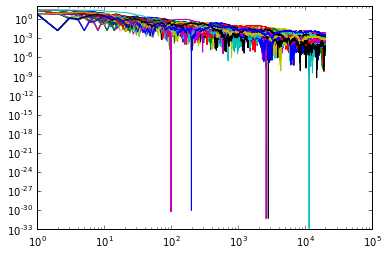

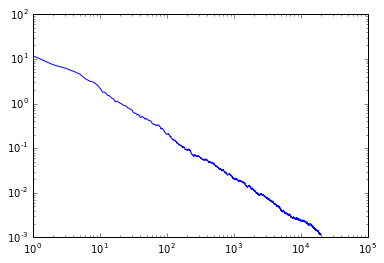

In [55]:
n_sim = 50
mse = {'wll': []}
K = 20000
for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print str(n+1),
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)
    # Estimation with virtual labels
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.cumsum(v, axis=0) / np.arange(1, K+1)[:,np.newaxis]

    mse_n = np.mean((f_v - eta)**2, axis=1)
    mse['wll'].append(mse_n)

plt.loglog(np.array(mse['wll']).T)
plt.show()
plt.loglog(np.mean(np.array(mse['wll']), axis=0))
plt.show()



In [53]:
n_sim = 100
mse = {'sup': [], 'wll': [], 'wml': []}

for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print str(n+1),
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)
    mse['sup'].append(np.sum((f - eta)**2))

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    mse['wll'].append(np.mean((f_v - eta)**2))

    # ML estimate
    f_ml = computeML(iz, M, max_iter=1000)
    mse['wml'].append(np.sum((f_ml - eta)**2))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


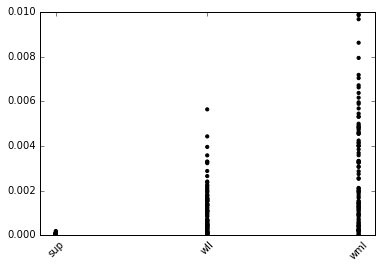

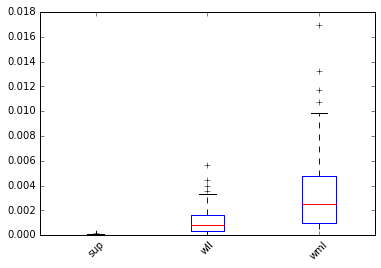

In [54]:
tag_list = ['sup', 'wll', 'wml']
for i, tag in enumerate(tag_list):
    plt.scatter([i + 1]*n_sim, mse[tag], c=[i]*n_sim, s=10, cmap='copper')

plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.axis('tight')
plt.ylim((0,0.01))
plt.show(block=False)

plt.boxplot([mse[tag] for tag in tag_list])
plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.show()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100

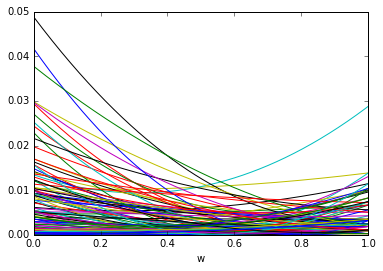

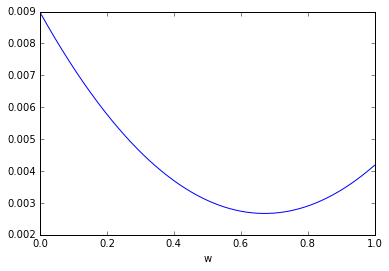

In [92]:
n_sim = 100
K = 50

mse = []
for n in range(n_sim):

    if (n+1)/1*1 == n+1:
        print str(n+1),

    # Generate fully labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weakly labeled dataset
    iy = np.random.choice(np.arange(0, C), size=50*K, p=eta)
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    
    w = np.arange(0, 1, 0.001)[:, np.newaxis]
    f_est = f * w + f_v * (1 - w)
    mse_n = np.mean((f_est - eta)**2, axis=1)
    mse.append(mse_n)

plt.plot(w.flatten(), np.array(mse).T)
plt.xlabel('w')
plt.show()

plt.plot(w.flatten(), np.mean(np.array(mse), axis=0))
plt.xlabel('w')
plt.show()
